In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib.animation as animation

In [43]:
data = pd.read_csv(r"C:\IITB\Leena Ma'am\Summer\INTERACTION-Dataset-TC-v1_0\INTERACTION-Dataset-TC-v1_0\recorded_trackfiles\TC_BGR_Intersection_VA\vehicle_tracks_000.csv")


def generate_autonomous_car_data(timestamp):
    x = np.random.uniform(900, 1150)
    y = np.random.uniform(900, 1150)
    vx = np.random.uniform(-10, 10)
    vy = np.random.uniform(-10, 10)
    psi_rad = np.random.uniform(-np.pi, np.pi)
    return {'x': x, 'y': y, 'vx': vx, 'vy': vy, 'psi_rad': psi_rad}


grid_size = 50 
radius = 50
fov = 120
angle_step = 0.05

In [44]:
def create_grids(data, grid_size):
    data['grid_x'] = (data['x'] // grid_size).astype(int)
    data['grid_y'] = (data['y'] // grid_size).astype(int)
    return data

In [45]:
def get_nearby_grids(autonomous_car, grid_size, radius):
    grid_x = int(autonomous_car['x'] // grid_size)
    grid_y = int(autonomous_car['y'] // grid_size)
    grid_radius = int(radius // grid_size)
    grids = [(i, j) for i in range(grid_x - grid_radius, grid_x + grid_radius + 1)
                     for j in range(grid_y - grid_radius, grid_y + grid_radius + 1)]
    return grids

In [46]:
def filter_cars_by_grid(data, grids):
    return data[data[['grid_x', 'grid_y']].apply(tuple, axis=1).isin(grids)]

def filter_cars_by_radius(data, autonomous_car, radius):
    distances = np.sqrt((data['x'] - autonomous_car['x'])**2 + (data['y'] - autonomous_car['y'])**2)
    return data[distances <= radius]

def filter_cars_by_fov(data, autonomous_car, fov):
    relative_angles = np.arctan2(data['y'] - autonomous_car['y'], data['x'] - autonomous_car['x'])
    car_angles = np.mod(relative_angles - autonomous_car['psi_rad'] + np.pi, 2 * np.pi) - np.pi
    fov_half_angle = np.radians(fov) / 2
    return data[np.abs(car_angles) <= fov_half_angle]

In [47]:
def discretize_angles(data, autonomous_car, angle_step):
    relative_angles = np.arctan2(data['y'] - autonomous_car['y'], data['x'] - autonomous_car['x'])
    car_angles = np.mod(relative_angles - autonomous_car['psi_rad'] + np.pi, 2 * np.pi) - np.pi
    fov_half_angle = np.radians(fov) / 2
    
    data_in_fov = data[np.abs(car_angles) <= fov_half_angle].copy()
    
    discrete_angles = np.arange(-fov_half_angle, fov_half_angle + np.radians(angle_step), np.radians(angle_step))
    data_in_fov['discrete_angle'] = np.digitize(car_angles[np.abs(car_angles) <= fov_half_angle], discrete_angles) * angle_step
    return data_in_fov

In [48]:
data = create_grids(data, grid_size)

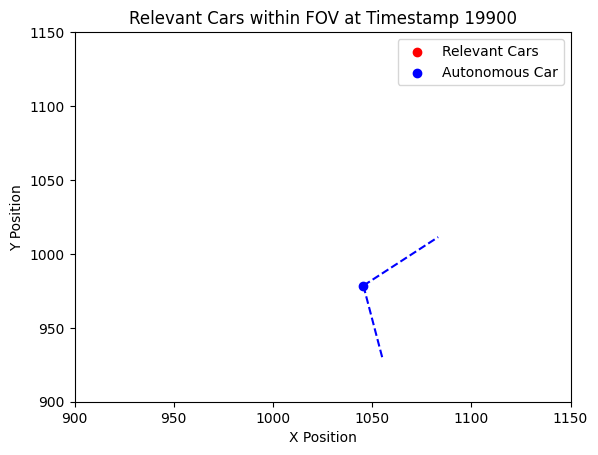

In [50]:
fig, ax = plt.subplots()

unique_timestamps = data['timestamp_ms'].unique()[:200]
def update(frame):
    timestamp = unique_timestamps[frame]
    
    timestamp_data = data[data['timestamp_ms'] == timestamp]

    autonomous_car = generate_autonomous_car_data(timestamp)

    nearby_grids = get_nearby_grids(autonomous_car, grid_size, radius)

    nearby_cars = filter_cars_by_grid(timestamp_data, nearby_grids)
    relevant_cars = filter_cars_by_radius(nearby_cars, autonomous_car, radius)
    relevant_cars = filter_cars_by_fov(relevant_cars, autonomous_car, fov)

    relevant_cars = discretize_angles(relevant_cars, autonomous_car, angle_step)

    ax.clear()
    ax.scatter(relevant_cars['x'], relevant_cars['y'], c='red', label='Relevant Cars')
    ax.scatter(autonomous_car['x'], autonomous_car['y'], c='blue', label='Autonomous Car')
    angle = autonomous_car['psi_rad']
    x, y = autonomous_car['x'], autonomous_car['y']
    fov_left = angle - np.radians(fov) / 2
    fov_right = angle + np.radians(fov) / 2
    ax.plot([x, x + radius * np.cos(fov_left)], [y, y + radius * np.sin(fov_left)], 'b--')
    ax.plot([x, x + radius * np.cos(fov_right)], [y, y + radius * np.sin(fov_right)], 'b--')
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title(f'Relevant Cars within FOV at Timestamp {timestamp}')
    ax.legend()
    ax.set_xlim(900, 1150)
    ax.set_ylim(900, 1150)

ani = animation.FuncAnimation(fig, update, frames=len(unique_timestamps), interval=500, repeat=False)
ani.save('car_animation.gif', writer='pillow')  

plt.show()

In [51]:
# def plot_relevant_cars(relevant_cars, autonomous_car, timestamp, ax, fig):
#     ax.clear()  # Clear the previous plot
#     ax.scatter(relevant_cars['x'], relevant_cars['y'], c='red', label='Relevant Cars')
#     ax.scatter(autonomous_car['x'], autonomous_car['y'], c='blue', label='Autonomous Car')
#     angle = autonomous_car['psi_rad']
#     x = autonomous_car['x']
#     y = autonomous_car['y']
#     fov_left = angle - np.radians(fov) / 2
#     fov_right = angle + np.radians(fov) / 2
#     ax.plot([x, x + radius * np.cos(fov_left)], [y, y + radius * np.sin(fov_left)], 'b--')
#     ax.plot([x, x + radius * np.cos(fov_right)], [y, y + radius * np.sin(fov_right)], 'b--')
#     ax.set_xlabel('X Position')
#     ax.set_ylabel('Y Position')
#     ax.set_title(f'Relevant Cars within FOV at Timestamp {timestamp}')
#     ax.legend()
#     ax.set_xlim(900, 1150)
#     ax.set_ylim(900, 1150)
#     fig.canvas.draw()
#     fig.canvas.flush_events()

In [ ]:
# fig, ax = plt.subplots()
# plt.ion() 
# unique_timestamps = data['timestamp_ms'].unique()[:15]

# for timestamp in unique_timestamps:
#     # Filter data for the current timestamp
#     timestamp_data = data[data['timestamp_ms'] == timestamp]

#     # Generate autonomous car data for the current timestamp
#     autonomous_car = generate_autonomous_car_data(timestamp)

#     # Get nearby grids
#     nearby_grids = get_nearby_grids(autonomous_car, grid_size, radius)

#     # Filter cars
#     nearby_cars = filter_cars_by_grid(timestamp_data, nearby_grids)
#     relevant_cars = filter_cars_by_radius(nearby_cars, autonomous_car, radius)
#     relevant_cars = filter_cars_by_fov(relevant_cars, autonomous_car, fov)

#     # Discretize angles
#     relevant_cars = discretize_angles(relevant_cars, autonomous_car, angle_step)

#     # Update the plot for the current timestamp
#     plot_relevant_cars(relevant_cars, autonomous_car, timestamp, ax, fig)
    
#     plt.pause(0.5)  # Pause to create animation effect

# plt.ioff()  # Turn off interactive mode
# plt.show()
# print("Animation completed successfully!")

In [38]:
# def plot_relevant_cars(relevant_cars, autonomous_car, timestamp):
#     fig, ax = plt.subplots()
#     #plt.figure(figsize=(1200,1200))
#     ax.scatter(relevant_cars['x'], relevant_cars['y'], c='red', label='Relevant Cars')
#     ax.scatter(autonomous_car['x'], autonomous_car['y'], c='blue', label='Autonomous Car')
#     angle = autonomous_car['psi_rad']
#     x = autonomous_car['x']
#     y = autonomous_car['y']
#     fov_left = angle - np.radians(fov) / 2
#     fov_right = angle + np.radians(fov) / 2
#     ax.plot([x, x + radius * np.cos(fov_left)], [y, y + radius * np.sin(fov_left)], 'b--')
#     ax.plot([x, x + radius * np.cos(fov_right)], [y, y + radius * np.sin(fov_right)], 'b--')
#     ax.set_xlabel('X Position')
#     ax.set_ylabel('Y Position')
#     ax.set_title(f'Relevant Cars within FOV at Timestamp {timestamp}')
#     ax.legend()
#     ax.set_xlim(900, 1150)
#     ax.set_ylim(900, 1150)
#     plt.show()
#     plt.close(fig)

In [ ]:
# unique_timestamps = data['timestamp_ms'].unique()[:15]

# for timestamp in unique_timestamps:
#     # Filter data for the current timestamp
#     timestamp_data = data[data['timestamp_ms'] == timestamp]

#     # Generate autonomous car data for the current timestamp
#     autonomous_car = generate_autonomous_car_data(timestamp)

#     # Get nearby grids
#     nearby_grids = get_nearby_grids(autonomous_car, grid_size, radius)

#     # Filter cars
#     nearby_cars = filter_cars_by_grid(timestamp_data, nearby_grids)
#     relevant_cars = filter_cars_by_radius(nearby_cars, autonomous_car, radius)
#     relevant_cars = filter_cars_by_fov(relevant_cars, autonomous_car, fov)

#     # Discretize angles
#     relevant_cars = discretize_angles(relevant_cars, autonomous_car, angle_step)

#     # Plot relevant cars for the current timestamp
#     plot_relevant_cars(relevant_cars, autonomous_car, timestamp)
# print("All plots saved successfully!")